## Predict the number of bikers in DC today <img src="../images/bicycle32.png" style="float:right">

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, f1_score

from ipywidgets import widgets, interact, interact_manual, fixed
from IPython.display import display, clear_output, HTML

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 5_000
sns.set(style="darkgrid")
%matplotlib inline

In [2]:
def on_predict_submit(incoming):
    # Insert values into dataframe
    X_input = []
    X_input = pd.DataFrame(columns=['season', 'year', 'month', 'weekday', 'is_holiday','is_workingday', 'weather', 'temp', 'temp_feel', 'humidity', 'windspeed'])
    input_variables = [input_month.value, '1', input_month.value, input_weekday.value, input_is_holiday.value, input_is_workingday.value, input_weather.value, input_temp.value/100, input_temp_feel.value/100, input_humidity.value, input_windspeed.value]
    X_input.loc[1] = [x for x in input_variables]
    map_list = ['season', 'year', 'month', 'weekday', 'is_holiday','is_workingday', 'weather']
    X_input = map_to_numeric(X_input, columns=map_list)
    X_input = pd.get_dummies(X_input, columns=['is_holiday', 'is_workingday', 'weather'], drop_first=True)
    X_input = equalize_features(X_features, X_input)
    #print(X_input.info())
    print(f"Predicted users in Washington DC today: {mlr.predict(X_input)[0][0]/10:,.0f}")

In [3]:
# Input month
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
input_month = widgets.ToggleButtons(
    options=months,
    description='Month',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=months
)
display(input_month)

# Input weekday
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
input_weekday = widgets.ToggleButtons(
    options=weekdays,
    description='Day',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=weekdays
)
display(input_weekday)

# Input is_workingday
is_workingdays = ['Yes', 'No']
input_is_workingday = widgets.ToggleButtons(
    options=is_workingdays,
    description='Work day?',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=is_workingdays
)
display(input_is_workingday)

# Input is_holiday
is_holidays = ['Yes', 'No']
input_is_holiday = widgets.ToggleButtons(
    options=is_holidays,
    description='Holiday?',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=is_holidays
)
display(input_is_holiday)

# Input weather
weathers = ['Clear', 'Mist', 'Light snow', 'Heavy rain']
input_weather = widgets.ToggleButtons(
    options=weathers,
    description='Weather',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=weathers
)
display(input_weather)

# Input temp
input_temp = widgets.FloatSlider(
    value=55.0,
    min=0,
    max=100.0,
    step=0.1,
    description='Temperature',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
display(input_temp)

# Input temp_feel
input_temp_feel = widgets.FloatSlider(
    value=55.0,
    min=0,
    max=100.0,
    step=0.1,
    description='Feels like',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
display(input_temp_feel)

# Input humidity
input_humidity = widgets.FloatSlider(
    value=0.50,
    min=0,
    max=1.00,
    step=0.01,
    description='Humidity',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
display(input_humidity)

# Input windspeed
input_windspeed = widgets.FloatSlider(
    value=0.20,
    min=0,
    max=0.70,
    step=0.01,
    description='Windspeed',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
display(input_windspeed)

# Input Predict
input_predict = widgets.Button(
    value=False,
    description='Predict',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Predict',
    icon='check'
)
display(input_predict)
input_predict.on_click(on_predict_submit)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [4]:
def equalize_features(model_features, new_df):
    new_features = new_df.columns.tolist()
    if set(model_features) != set(new_features):
        missing_cols = set(model_features) - set(new_features)
        for col in missing_cols:
            new_df[col] = 0
    
    if set(new_features) != set(model_features):
        missing_cols = set(new_features) - set(model_features)
        new_df = new_df.drop(missing_cols, axis=1)
    
    new_df = new_df[model_features]
    return new_df

In [5]:
# Map values to numeric
def map_to_numeric(X_input, columns):
    for column in columns:
        map_dict = get_map_dict(column)
        X_input[column] = X_input[column].map(map_dict)
    return X_input
    
def get_map_dict(feature):
    map_feature = {
    'season': {
        'Jan': 4,
        'Feb': 4,
        'Mar': 1,
        'Apr': 1,
        'May': 1,
        'Jun': 2,
        'Jul': 2,
        'Aug': 2,
        'Sep': 3,
        'Oct': 3,
        'Nov': 3,
        'Dec': 4,
        }, 
    'year': {
        '1': 1,
        '0': 0
        },
    'month': {
        'Jan': 1,
        'Feb': 2,
        'Mar': 3,
        'Apr': 4,
        'May': 5,
        'Jun': 6,
        'Jul': 7,
        'Aug': 8,
        'Sep': 9,
        'Oct': 10,
        'Nov': 11,
        'Dec': 12
        }, 
    'weekday': {
        'Sun': 0,
        'Mon': 1,
        'Tue': 2,
        'Wed': 3,
        'Thu': 4,
        'Fri': 5,
        'Sat': 6
        },
    'is_workingday': {
        'Yes': 1,
        'No': 0
        },
    'is_holiday': {
        'Yes': 1,
        'No': 0
        },
    'weather': {
        'Clear': 0,
        'Mist': 1,
        'Light Snow': 2,
        'Heavy Rain': 3
        }
    }
    return map_feature[feature]

In [6]:
# Function prepare_data: Rename and rearrange columns and convert to datetime format where appropriate
# Input df: dataframe object
def prepare_data(df):
    # Convert column names to lowercase with spaces replaced by underscores
    df.columns = df.columns.str.lower().str.replace(' ', '_').tolist() 
    # Convert 'dteday' to datetime
    df[['dteday']] = df[['dteday']].apply(pd.to_datetime)
    # Rename columns
    df = df.rename(columns={
        'instant': 'id',
        'dteday': 'date',
        'season': 'season',
        'yr': 'year',
        'mnth': 'month',
        'holiday': 'is_holiday',
        'weekday': 'weekday',
        'workingday': 'is_workingday',
        'weathersit': 'weather',
        'temp': 'temp',
        'atemp': 'temp_feel',
        'hum': 'humdity',
        'windspeed': 'windspeed',
        'casual': 'casual',
        'registered': 'registered',
        'cnt': 'count'})
    return df

In [7]:
# Function count_users_by: Count the number of users in a day ('count') grouped by the category specified
#  Input df: dataframe object
#        category: the particular column that the count should be grouped by
def count_users_by(df, category):
    category_sum = df.groupby(category)['count'].sum()
    category_count = df.groupby(category)['count'].count()
    print(f"Counts: {category_count}")
    print(f"Sum: {category_sum}")
    ax = sns.barplot(category_sum.index, category_sum.values)

In [8]:
# Function fit_model: Returns optimal fitted model
#  Input X: Feature set (from training data)
#        y: Target values (from training data)
#        model_name: Default='lr'. Abbreviation/name of model (to be used to identify model in Pipeline)
#        model_type: Default=LinearRegression(). Model to use to fit data. Must be imported accordingly and corresponds to model_name
#        parameters: Default={'polynomial__degree': [1, 2]}. Parameters to be tuned in GridSearchCV. Must correspond to arguments for model_type.
def fit_model(X, y, model_name='mlr', model_type=LinearRegression(), parameters={'polynomial__include_bias': False, 'polynomial__degree': [1, 2]}):
    # Build pipeline to engineer features and fit model
    pm = Pipeline([
        ('polynomial', PolynomialFeatures()),
        ('scale', StandardScaler()),
        (model_name, model_type)
    ])
    model = pm.fit(X_train, y_train)
    
    # Build grid using pipeline to fit model
    parameters = parameters
    grid = GridSearchCV(pm, parameters)
    model_optimal = grid.fit(X_train, y_train)

    # Print best attributes
    best_params = grid.best_params_
    best_score = grid.best_score_
    #print(f'For model: {model_type}')
    #print(f'The best parameters are: {best_params}')
    #print(f'The best score is: {best_score:.4f}')
    
    return model_optimal

In [9]:
# Function evaluate_model: Evaluate model
#  Input model: Model object containing fitted data
#        X_train, X_test, y_train, y_test: Training and testing values for features and target
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Evaluate training data
    y_hat_train = model.predict(X_train)
    kf_train = KFold(shuffle=True, random_state=42)
    cvs_train = cross_val_score(model, X_train, y_train, cv=kf_train).mean()
    score_train = model.score(X_train, y_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_hat_train))

    # Evaluate testing data
    y_hat_test = model.predict(X_test)
    kf_test = KFold(shuffle=True, random_state=42)
    cvs_test = cross_val_score(model, X_test, y_test, cv=kf_test).mean()
    score_test = model.score(X_test, y_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_hat_test))
    
    # Print results
    #print(f'cvs mean score on training data: {cvs_train:.4f}')
    #print(f'cvs mean score on testing data: {cvs_test:.4f}')
    
    #print(f'Score on training data: {score_train:.4f}')
    #print(f'Score on testing data: {score_test:.4f}')
    
    #print(f'RMSE on training data: {rmse_train:.4f}')
    #print(f'RMSE on testing data: {rmse_test:.4f}')

In [10]:
# Read in dataset
df = pd.read_csv('../data/day.csv')

In [11]:
# Prepare dataset
df = prepare_data(df)

In [12]:
# Identify columns of interest for feature and target set
columns_of_interest = df.columns.difference(['id', 'date', 'casual', 'registered'])
df = df[columns_of_interest]

In [13]:
# Convert nominal variables to categorical
df = pd.get_dummies(df, columns=['is_holiday', 'is_workingday', 'weather'], drop_first=True)

In [14]:
# Define target and feature variables
target = ['count']
features = df.columns.difference(['count'])
y = df[target]
X = df[features]

[AccuWeather - Washington DC](https://www.accuweather.com/en/us/washington-dc/20006/daily-weather-forecast/327659?day=1)

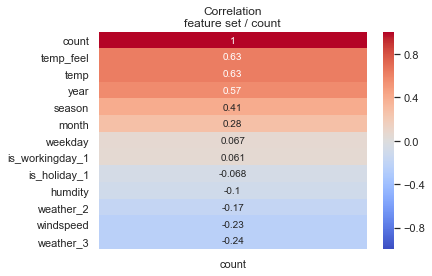

In [15]:
# Discover how feature variables correlate to target
df_corr = df.corr()[['count']].sort_values('count', ascending=False)
plt.title('Correlation\nfeature set / count')
sns.heatmap(df_corr, cmap='coolwarm', annot=True, vmin=-1, vmax=1);

In [16]:
# Split the data into training and testing datasets
X_train, X_test, y_train, y_test =  train_test_split(X, y, random_state=42, train_size=0.75)

In [17]:
parameters = {
    'polynomial__degree': [1, 2, 3],
    'mlr__n_jobs': [-2]
}
mlr = fit_model(X_train, y_train, model_name='mlr', model_type=LinearRegression(), parameters=parameters)

In [18]:
evaluate_model(mlr, X_train, X_test, y_train, y_test)

In [19]:
y_test_hat = mlr.predict(X_test)
predictions = y_test
predictions['y_test_hat'] = y_test_hat
predictions = predictions.rename(columns={'count': 'y_test'})

In [20]:
X_features = X_test.columns.tolist()

In [21]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script><a href="javascript:code_toggle()">Toggle</a> code.''')